In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en drive
import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

Mounted at /content/gdrive
/content


In [2]:
%cd '/content/gdrive/MyDrive/Curso Data Science para todos/Datos/'

/content/gdrive/MyDrive/Curso Data Science para todos/Datos



# ¿Qué características determinan el precio de un alquiler de Airbnb?

## Objetivos (2 min)
Este caso presenta a los estudiantes un recorrido relativamente completo de un proceso de **análisis de datos exploratorios (EDA)** en un conjunto de datos desconocido. Queremos que los estudiantes aprendan cómo abordar sistemáticamente la investigación de un conjunto de datos desconocido mientras mantienen la creatividad para buscar información. Al final, esperamos que los estudiantes tengan confianza para abordar conjuntos de datos fuera de un entorno estructurado y aprecien el enorme valor de un proceso EDA adecuado para cualquier problema de ciencia de datos.

In [3]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns

import folium  #needed for interactive map
from folium.plugins import HeatMap

from   collections           import Counter
from   sklearn               import preprocessing
from   datetime              import datetime
from   collections           import Counter
from   math                  import exp
from   sklearn.linear_model  import LinearRegression as LinReg
from   sklearn.metrics       import mean_absolute_error
from   sklearn.metrics       import median_absolute_error
from   sklearn.metrics       import r2_score


## Introduccion (5 min)

**Contexto de Negocio**. Airbnb es un enorme mercado en línea para que la gente común alquile lugares para quedarse. Es un mercado grande y lucrativo, pero muchos proveedores son simplemente personas que alquilan su propia residencia principal para visitas breves. Incluso los proveedores más grandes suelen ser pequeñas empresas con solo una pequeña cantidad de lugares para alquilar. Como resultado, tienen una capacidad limitada para evaluar tendencias a gran escala y establecer precios óptimos.

Airbnb ha lanzado un nuevo servicio para ayudar a los listers a establecer precios. Airbnb obtiene una comisión porcentual de los listados, por lo que se les incentiva a ayudar a los anunciantes a fijar precios de manera óptima; es decir, en el punto máximo posible en el que aún cerrarán un trato. Eres un consultor de Airbnb que ayuda con este nuevo servicio de precios.

**Problema de Negocio**. Su tarea inicial es explorar los datos con el objetivo de responder la pregunta: <b> "¿Qué características son más relevantes para el precio de un anuncio de Airbnb?"</b>

**Contexto analitico**. Usaremos el conjunto de datos con buena calidad y disponible públicamente creado por el grupo de defensa Inside Airbnb. Nos centraremos en los listados en la ciudad de Nueva York durante el último año, aprovechando conjuntos de datos más grandes cuando haya detalles importantes para explorar.

El caso está estructurado de la siguiente manera: 

1. haremos una exploración básica de datos trazando distribuciones de cantidades clave; 

2. introducir el concepto de correlación para encontrar las características clave; 

3. introducir la idea de efectos de interacción para corregir los efectos de características clave; 

4. discutir cómo generar hipótesis iterativamente y elegir visualizaciones de datos para respaldar sus conclusiones; 

5. Observe un tipo muy específico de efecto de interacción, el efecto temporal y cómo corregirlo; y finalmente 

6. juntar todo para identificar los factores clave que afectan el precio.

## Exploracion básica de la data (15 min)

Comenzamos cargando los datos y mirando su forma básica:

In [5]:
listings = pd.read_csv('airbnb_nyc.csv', delimiter=',')
print(listings.shape)
listings.head(3)

(30179, 81)


,id,name,summary,description,experiences_offered,neighborhood_overview,transit,house_rules,host_id,host_since,...,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,accessible,event_suitable
0,2539,Clean & quiet apt home by the park,Renovated apt home in elevator building.,Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,Very close to F and G trains and Express bus i...,-The security and comfort of all our guests is...,2787,39698.0,...,-1,1,1,-1,-1,1,1,-1,1,1
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,Upon arrival please have a legibile copy of yo...,4632,39777.0,...,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
2,7750,Huge 2 BR Upper East Cental Park,NaN,Large Furnished 2BR one block to Central Park...,none,NaN,NaN,NaN,17985,39953.0,...,-1,1,-1,1,-1,-1,-1,-1,-1,-1


In [6]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


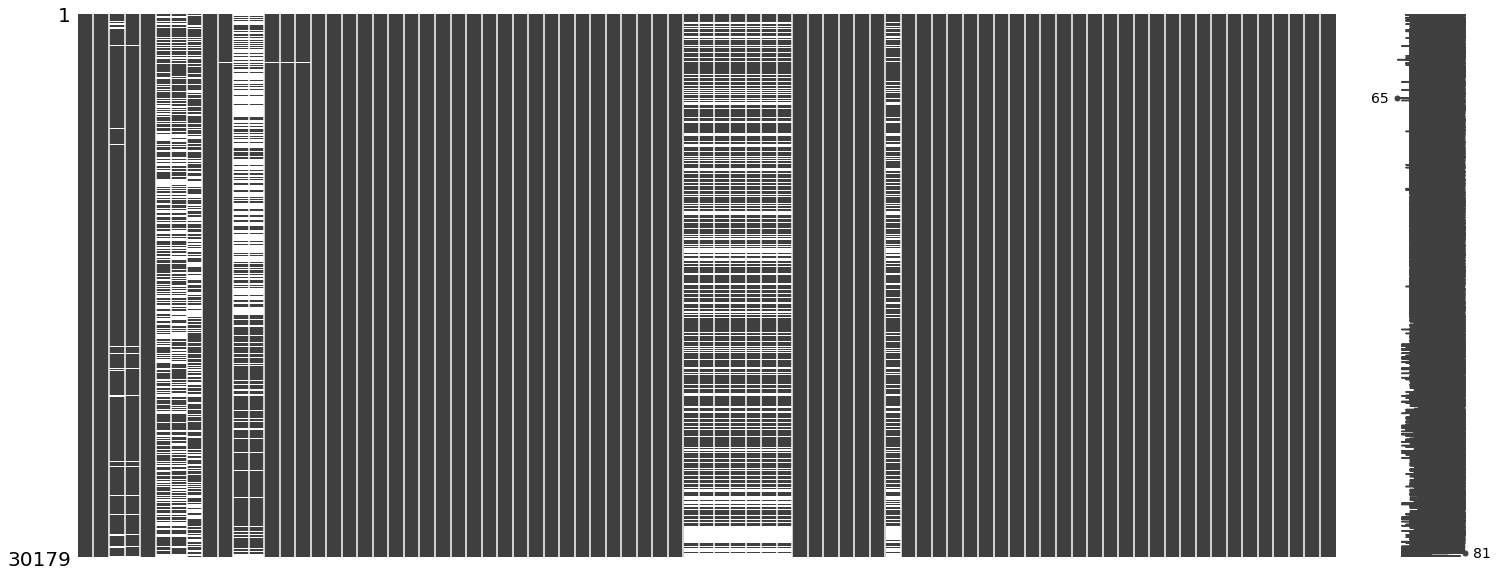

In [7]:
import missingno as msno
msno.matrix(listings)

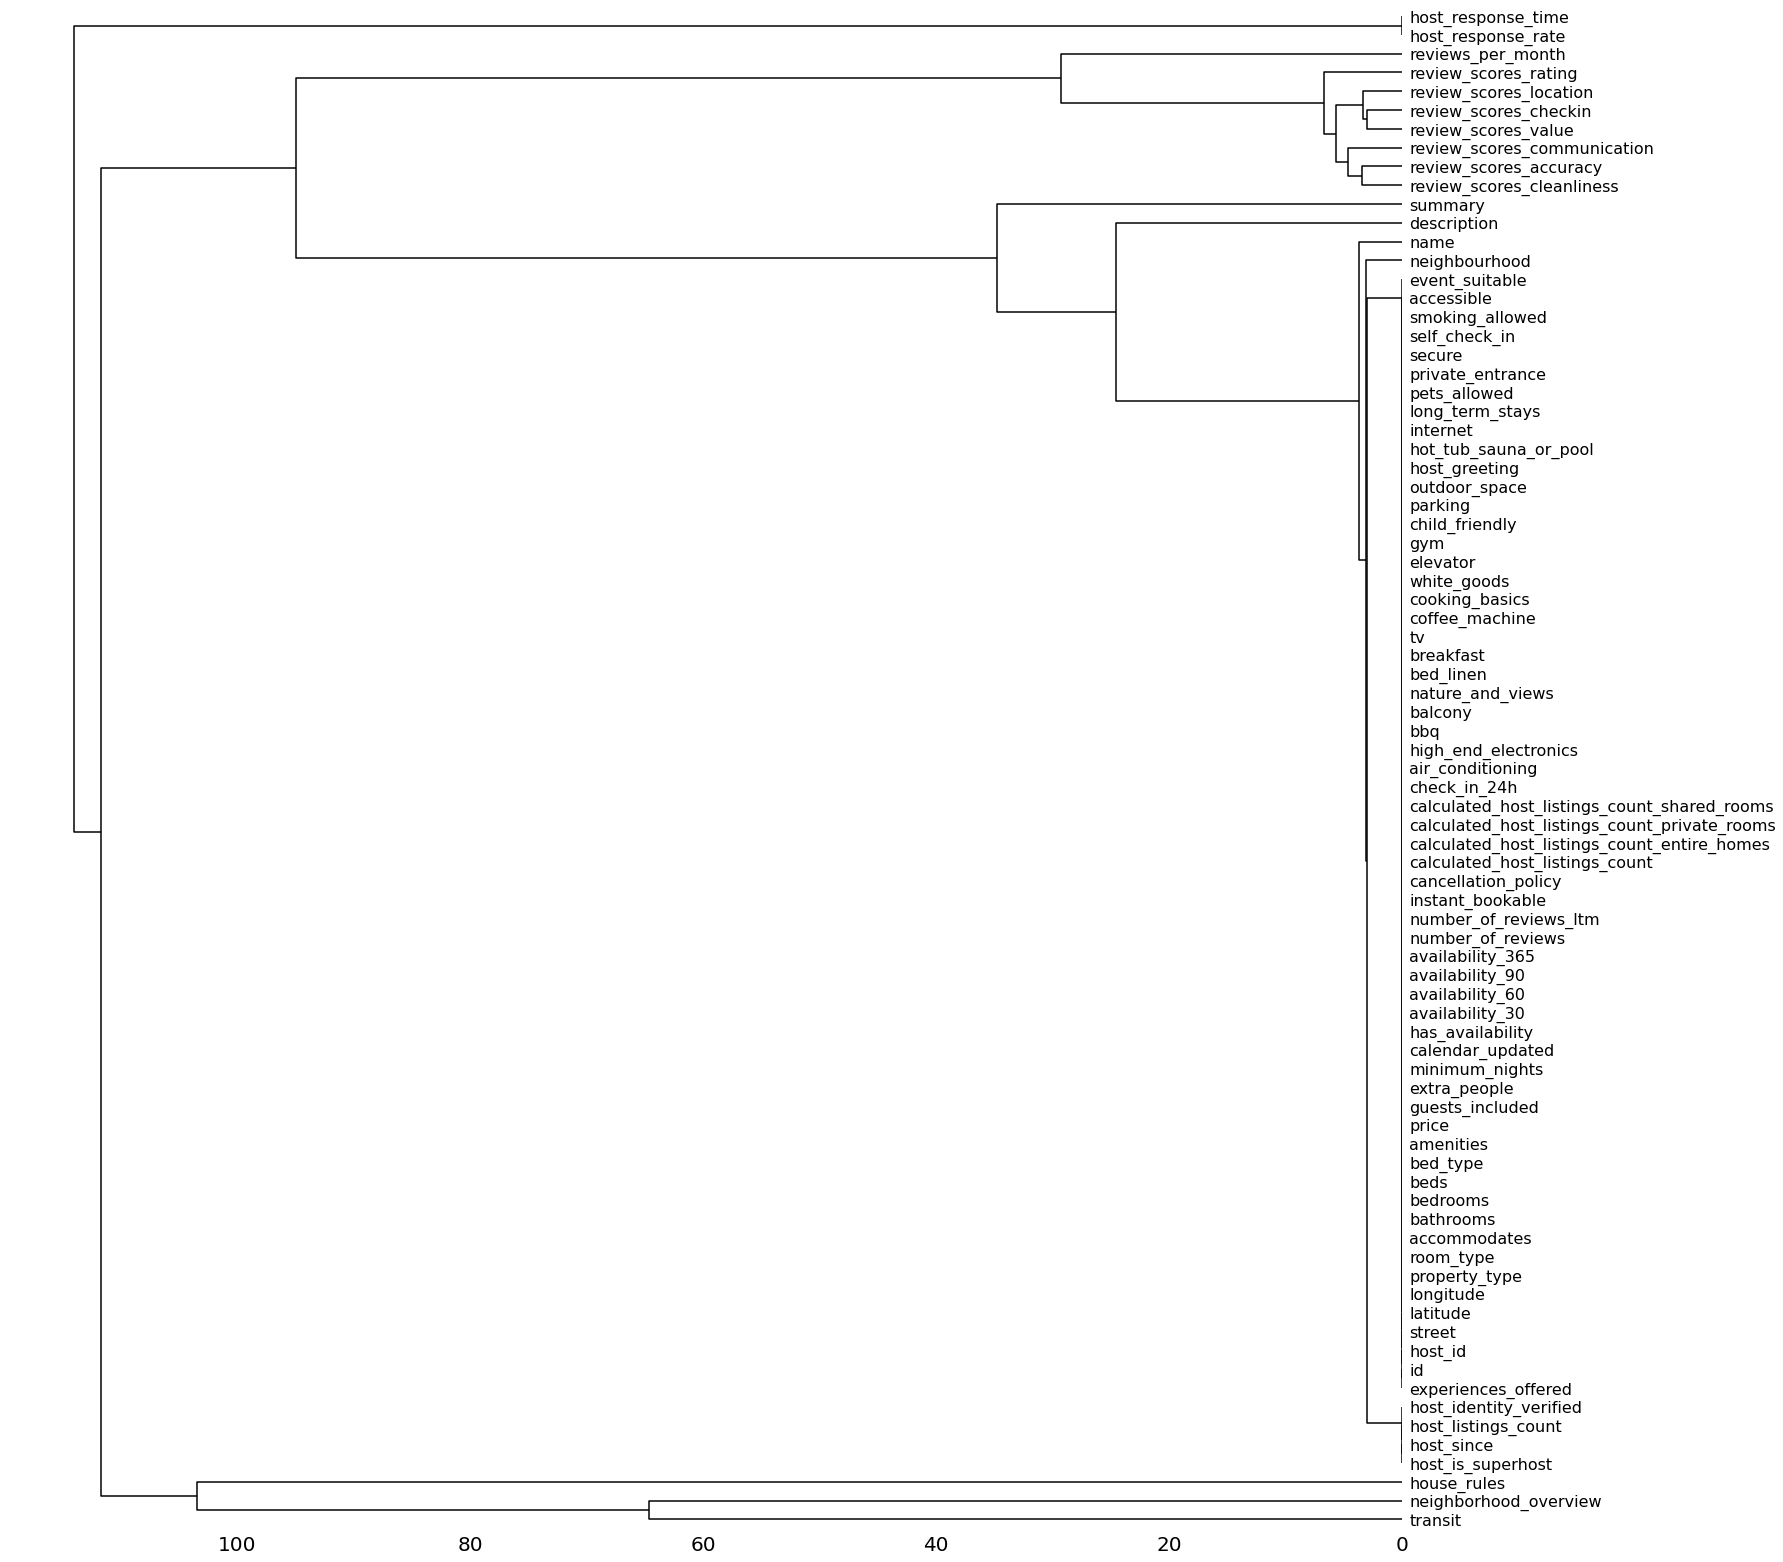

In [8]:
msno.dendrogram(listings)

In [9]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30179 entries, 0 to 30178
Data columns (total 81 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            30179 non-null  int64  
 1   name                                          30166 non-null  object 
 2   summary                                       28961 non-null  object 
 3   description                                   29575 non-null  object 
 4   experiences_offered                           30179 non-null  object 
 5   neighborhood_overview                         18113 non-null  object 
 6   transit                                       18190 non-null  object 
 7   house_rules                                   16623 non-null  object 
 8   host_id                                       30179 non-null  int64  
 9   host_since                                    30170 non-null 

In [10]:
listings.columns 

Index(['id', 'name', 'summary', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'host_id',
       'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'street', 'neighbourhood', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'calculated_host_listings_count',


In [11]:
# Obtengamos algun overview de los datos
pd.options.display.max_columns = 100
listings.head(3)

,id,name,summary,description,experiences_offered,neighborhood_overview,transit,house_rules,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,street,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,accessible,event_suitable
0,2539,Clean & quiet apt home by the park,Renovated apt home in elevator building.,Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,Very close to F and G trains and Express bus i...,-The security and comfort of all our guests is...,2787,39698.0,within an hour,1.0,0.0,6.0,1.0,"Brooklyn , NY, United States",Brooklyn,40.64749,-73.97237,Apartment,Private room,2,1.0,1,1,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",149,1,35,1,3 weeks ago,1,30,60,90,365,9,2,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,6,0,5,1,0.21,1,-1,-1,-1,-1,-1,1,-1,1,1,1,1,1,-1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,-1,1,1
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,Upon arrival please have a legibile copy of yo...,4632,39777.0,within a day,1.0,0.0,1.0,1.0,"New York, NY, United States",Harlem,40.80902,-73.94190,Apartment,Private room,2,1.0,1,1,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",150,2,20,3,34 months ago,1,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,strict_14_with_grace_period,1,0,1,0,NaN,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
2,7750,Huge 2 BR Upper East Cental Park,NaN,Large Furnished 2BR one block to Central Park...,none,NaN,NaN,NaN,17985,39953.0,within a day,1.0,0.0,2.0,1.0,"New York, NY, United States",Harlem,40.79685,-73.94872,Apartment,Entire home/apt,4,1.0,2,2,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",190,1,0,7,7 weeks ago,1,4,14,14,249,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,2,1,1,0,NaN,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1


Los siguientes son detalles sobre algunas de las columnas importantes aquí:

1. ```neighbourhood```:  el barrio/neighborhood donde esta la propiedad
2. ```longitude```, ```latitude```: longitud y latitud
3. ```property_type```: tipo de propiedad como apartamento, condominio, etc
4. ```bathrooms```: numero de baños
5. ```bedrooms```: numero de camas
6. ```price```:  precio del lugar
7. ```number_of_reviews```: numero de reviews dados por los clientes que han estado en la propiedad
8. ```parking```: 1 indica que si hay parking, -1 lo contrario

Para variables categoricas, como ```outdoor_friendly```, ```gym```, etc., el 1,-1 se deben interpretar como ```parking```.

### Graficar la distribucion marginal de las principales cantidades de interes
Como ha visto en los casos de Python, es bueno desarrollar primero una idea de cómo se distribuyen los valores de algunas cantidades clave de interés. Siempre comenzamos a investigar obteniendo una vista general de varios parámetros en nuestros datos. Comencemos por hacerlo para algunas variables numéricas, como ```price```, ```bedrooms```, ```bathrooms```, ```number_of_reviews```:

### Ejercicio 1: (12 min)

#### 1.1 (2 min)

Usar la propiedad [describe()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) y [quantile()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html) permite calcular un summary de las cantidades estadisticas mas importantes.

**Respuesta.**

In [12]:
listings[['price','bedrooms','bathrooms','number_of_reviews','parking']].describe()

,price,bedrooms,bathrooms,number_of_reviews,parking
count,30179.000000,30179.000000,30179.000000,30179.000000,30179.000000
mean,132.949965,1.265516,1.151595,4.459889,-0.394877
std,93.151824,0.614659,0.422225,5.265633,0.918749
min,0.000000,1.000000,0.500000,0.000000,-1.000000
25%,65.000000,1.000000,1.000000,0.000000,-1.000000
50%,100.000000,1.000000,1.000000,2.000000,-1.000000
75%,175.000000,1.000000,1.000000,7.000000,1.000000
max,500.000000,11.000000,7.500000,20.000000,1.000000


In [13]:
listings['price'].quantile([0.9,0.95,0.99])

0.90    250.0
0.95    325.0
0.99    450.0
Name: price, dtype: float64

In [14]:
for i, var in enumerate(vars_to_plot):listings['number_of_reviews'].describe()

count    30179.000000
mean         4.459889
std          5.265633
min          0.000000
25%          0.000000
50%          2.000000
75%          7.000000
max         20.000000
Name: number_of_reviews, dtype: float64

#### 1.2 (4 min)

Usar la función [plt.hist()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html) para hacer un histograma de las variables anteriores. Como es la estructura de la grafica en terminos de la forma (e.g. normal, skewed, multi-modal, etc.)?

**Respuesta.** 

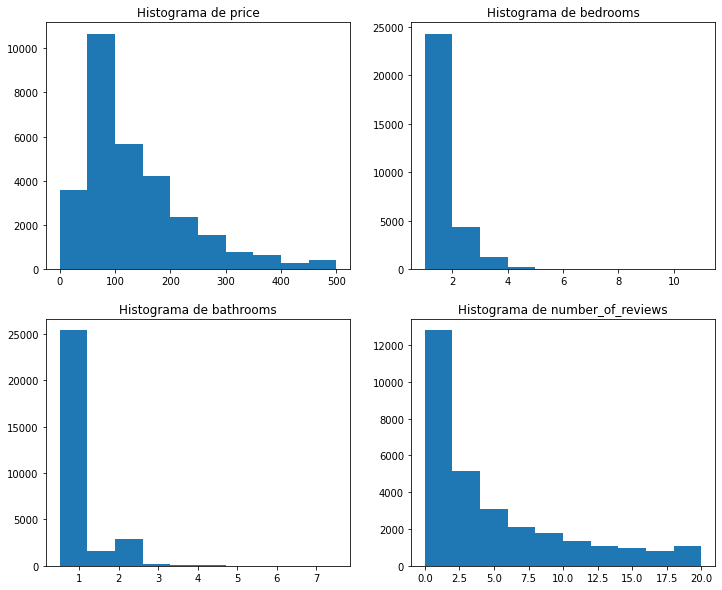

In [15]:
plt.figure(figsize=(12,10))
vars_to_plot = ['price', 'bedrooms','bathrooms','number_of_reviews']
for i, var in enumerate(vars_to_plot):
    plt.subplot(2,2,i+1) # 2 filas dos columnas 
    plt.hist(listings[var],10) # 10 representa el numero de bins 
    title_string = "Histograma de " + var 
    plt.title(title_string)

#### 1.3 (2 min)

¿Son las distribuciones bastante suavizadas o muestran un comportamiento "puntiagudo" o "discontinuo"? Si es lo último, ¿puede explicar de dónde podría provenir?

**Respuesta.** La variable ```price``` es nototoriamente spiky (puntiaguda). Hay una buena cantidad de precios entre 25 y 300 dólares, con picos muy obvios en números redondos como 50, 100, 150, 200, 250 y 300. Esto probablemente refleja el hecho de que las personas ingresan en los precios que desean proponer, por lo que tienden a elegir números redondos (o números justo debajo de los números redondos).

#### 1.4 (4 min)

¿Puede detectar valores atípicos de estos histogramas? Si es así, sugieren (i) error en los datos; o (ii) datos que deberían omitirse de nuestro análisis futuro?

**Respuesta.** Muy pocos lugares tenían precios de más de $320, por lo que podríamos considerarlos como **valores atípicos**. 

Algunos de estos pueden representar un error, pero creemos que la mayoría de ellos son correctos: los hoteles en Nueva York ciertamente cuestan más de 400 dólares la noche, por lo que no es descabellado esperar algunos listados de Airbnb de este precio. 

La cuestión de si debemos omitir estos valores atípicos es un poco más difícil, pero nos inclinamos a omitirlos para <b>la mayoría</b> de los clientes. Incluso si estos precios son correctos, sospechamos que se rigen por factores idiosincrásicos que no son tan relevantes para los listados que la mayoría de nuestros clientes están interesados en analizar. Por lo tanto, tenderán a darnos resultados engañosos (o "sesgados").

Es importante tener en cuenta que nunca omitimos datos por conveniencia o por razones arbitrarias. Solo omitimos datos cuando existe una razón lógica por la que incluirlos arruinaría nuestro análisis.

### Otra forma de mostrar el histograma de numero de camas

A veces, es mejor mirar un histograma que traza los porcentajes <i>relativos</i> de valores en todas las categorías:

In [18]:
bedrooms_counts = Counter(listings.bedrooms)
print('--------------------------------------')
print(bedrooms_counts)

--------------------------------------
Counter({1: 24254, 2: 4321, 3: 1241, 4: 279, 5: 62, 6: 14, 7: 4, 8: 3, 11: 1})


In [ ]:
bedrooms_counts = Counter(listings.bedrooms)
print('--------------------------------------')
print(bedrooms_counts)

tdf =pd.DataFrame.from_dict(bedrooms_counts, orient = 'index').sort_values(by = 0)
print('--------------------------------------')
print(tdf)

tdf = (tdf.iloc[-10:, :] / len(listings)) * 100
print('--------------------------------------')
print(tdf)

# Ordenar el dataframe por el numero
tdf.sort_index(axis = 0, ascending = True, inplace = True)
tdf
print('--------------------------------------')
print(tdf)

--------------------------------------
Counter({1: 24254, 2: 4321, 3: 1241, 4: 279, 5: 62, 6: 14, 7: 4, 8: 3, 11: 1})
--------------------------------------
        0
11      1
8       3
7       4
6      14
5      62
4     279
3    1241
2    4321
1   24254
--------------------------------------
            0
11   0.003314
8    0.009941
7    0.013254
6    0.046390
5    0.205441
4    0.924484
3    4.112131
2   14.317903
1   80.367143
--------------------------------------
            0
1   80.367143
2   14.317903
3    4.112131
4    0.924484
5    0.205441
6    0.046390
7    0.013254
8    0.009941
11   0.003314


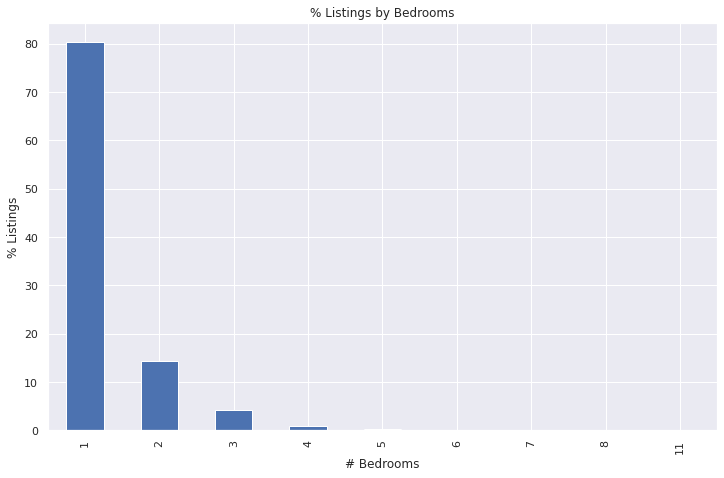

In [ ]:
ax = tdf.plot(kind = 'bar', figsize = (12, 7.5))
ax.set_xlabel("# Bedrooms")
ax.set_ylabel("% Listings")
ax.set_title('% Listings by Bedrooms')
ax.legend_.remove()
plt.show()

## Inspeccionando el precio vs variables de interes (10 min)

Ahora que hemos analizado las variables de interés de forma aislada, tiene sentido analizarlas en relación con el precio.

### Ejercicio 2: (10 min)

#### 2.1 (5 min)
Escriba un codigo para hacer un boxplot de ```price``` vs. ```bedrooms```, ```bathrooms```, ```number_of_reviews```, ```review_scores_cleanliness```.

**Respuesta.**

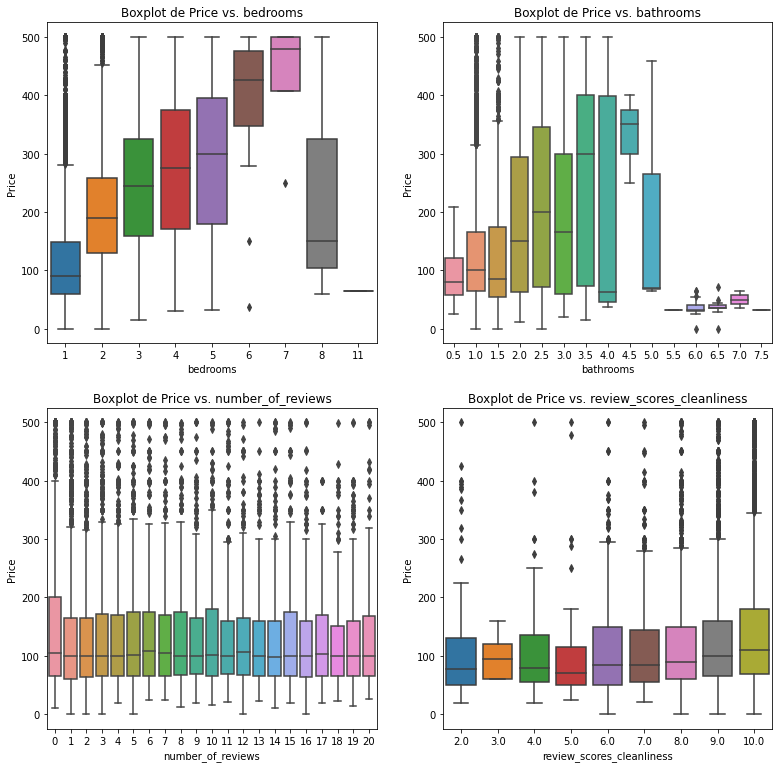

In [19]:
plt.figure(figsize=(13,13))
vars_to_plot = ['bedrooms','bathrooms','number_of_reviews','review_scores_cleanliness']
for i, var in enumerate(vars_to_plot):
    plt.subplot(2,2,i+1) # Figura 2 filas y 2 columnas
    sns.boxplot(x = var, y='price', data = listings)
    title_string = "Boxplot de Price vs. " + var # titulo iterativo
    plt.ylabel("Price")
    plt.title(title_string)

#### 2.2 (5 min)

Comente la relación entre el precio y la variable respectiva en cada una de las gráficas anteriores.

**Respuesta.**

1. Como era de esperar, el precio medio aumenta con la cantidad de dormitorios. Esta relación también parece lineal.
2. Nuevamente, como se esperaba, el precio promedio parece aumentar con el número de baños. Parece haber algunos valores atípicos que desafían esta tendencia.
3. El número de reseñas no parece afectar el precio medio.
4. Parece haber un ligero aumento en el precio medio con un aumento en las puntuaciones de las revisiones de limpieza.

## Investigando correlaciones (15 min)

Aunque trazar la relación entre el precio y algunas otras variables es un buen primer paso, en general hay demasiadas variables para trazar individualmente e inspeccionar manualmente. Necesitamos un método más sistemático. ¿Como procedemos? Una forma sencilla de obtener una descripción general rápida de las variables clave que afectan el precio es a través de la <b>correlación </b>.

Echemos un vistazo a ```price``` vs. ```bedrooms``` :

Text(0.5, 1.0, 'Boxplot de Price vs. Bedrooms')

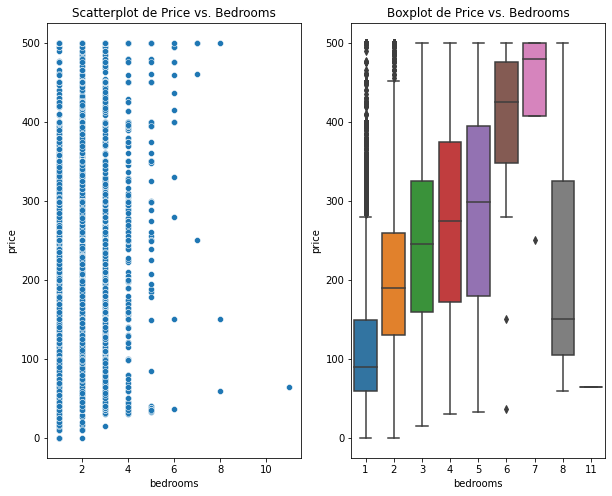

In [20]:
plt.figure(figsize=(10,8))
plt.subplot(121)
sns.scatterplot(x='bedrooms',y = 'price', data = listings)
plt.ylabel("price")
plt.title("Scatterplot de Price vs. Bedrooms")
plt.subplot(122)
sns.boxplot(x='bedrooms',y= 'price', data = listings)
plt.ylabel("price")
plt.title("Boxplot de Price vs. Bedrooms")

Vemos que a medida que aumenta el número de dormitorios, el precio en promedio aumenta. La <b>correlación</b> de cantidades es una forma de capturar esta relación. La correlación de dos cantidades es una medida de cuánto tienden a aumentar juntas, medida en una escala que va de -1 a 1. Una correlación positiva entre el precio y la cantidad de habitaciones indicaría que los listados de precios más altos tienden a tener <i>más</i> dormitorios. De manera similar, una correlación negativa entre el precio y la cantidad de dormitorios indicaría que los listados de precios más altos tienden a tener <i>menos</i> dormitorios. En nuestro caso, podemos ver fácilmente que el precio se correlaciona positivamente con las habitaciones.

Dado que la correlación es solo un número que resume una distribución conjunta completa, puede ser engañosa y no elimina la necesidad de graficar e inspeccionar visualmente las variables clave que sugiere que son importantes. No obstante, es muy útil cuando se busca rápidamente relaciones muy sólidas en los datos y se reduce una lista mucho más amplia de factores potenciales.

In [23]:
np.corrcoef(listings['price'],listings['bedrooms'])[0,1]

0.45453929526271664

La [correlation matrix](https://www.displayr.com/what-is-a-correlation-matrix/) da todas las correlaciones por pares entre todas las variables. Podemos obtener una descripción general rápida de las variables clave que afectan el precio mirando su fila en la matriz de correlación.

### Exercise 3 (10 min)

#### 3.1 (1 min)

Escriba código para calcular la matriz de correlación entre el precio y otras cantidades.
(usar .corr()). 

#### 3.2 (2 min)

Imprima las columnas que están correlacionadas positivamente, en orden creciente de correlación.

#### 3.3 (2 min)

Imprima las columnas que están correlacionadas negativamente, en orden creciente de la magnitud de la correlación.

**Respuesta.**

In [24]:
corr = listings.corr()
corr

,id,host_id,host_since,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,accessible,event_suitable
id,1.000000,0.567767,0.530654,0.103325,0.062122,0.071475,-0.351613,-0.005784,0.109353,0.095344,0.041364,0.052900,0.081639,0.027533,0.073860,0.015423,0.000090,NaN,0.275434,0.310207,0.323030,0.241093,-0.099074,0.281097,0.005712,-0.008610,0.051732,-0.026479,-0.046465,0.061172,0.018077,0.370174,0.119937,0.098897,0.111743,0.074851,0.557623,-0.238283,0.053860,0.001858,0.061554,0.073392,0.038773,0.197887,0.087920,0.007983,0.189066,0.179178,0.018486,-0.012869,0.060977,-0.335233,0.093657,0.065741,0.067887,-0.019574,0.004068,0.133459,-0.055286,0.264720,-0.062950,0.143029,0.002802,-0.074635,0.026211
host_id,0.567767,1.000000,0.905404,0.031051,0.002383,0.036721,-0.471233,0.025581,0.128454,0.103469,0.058319,0.055659,0.114607,0.028931,0.093609,0.030244,0.000424,NaN,0.293828,0.333110,0.350964,0.299765,-0.031790,0.191829,-0.082189,-0.089129,-0.001015,-0.084407,-0.105143,-0.016744,-0.063119,0.304739,0.150896,0.125094,0.140272,0.075075,0.431707,-0.149752,0.048199,-0.004128,0.006306,0.015449,0.024602,0.161820,0.024614,0.043710,0.140030,0.106922,-0.043834,-0.013130,0.034135,-0.233112,0.051000,0.008452,0.033211,-0.001314,-0.020248,0.121658,-0.046604,0.164151,-0.051488,0.039264,0.000612,-0.033810,0.014483
host_since,0.530654,0.905404,1.000000,0.029362,-0.005315,0.056799,-0.460919,0.043202,0.133671,0.059946,0.037348,0.021578,0.082001,-0.009671,0.051555,0.000478,-0.003294,NaN,0.239441,0.273200,0.291389,0.242459,-0.052206,0.162810,-0.090009,-0.087586,-0.022991,-0.082780,-0.104489,-0.027066,-0.065790,0.289922,0.144230,0.119375,0.134057,0.077951,0.360644,-0.126710,0.026867,-0.000546,0.003265,0.006753,0.026418,0.137461,0.023077,0.036480,0.115689,0.082969,-0.047184,-0.005512,0.034853,-0.213517,0.033959,0.003663,0.032550,0.008638,-0.024976,0.102444,-0.037173,0.134174,-0.033657,0.027736,0.017108,-0.038432,0.020046
host_response_rate,0.103325,0.031051,0.029362,1.000000,0.133280,0.071515,-0.021462,-0.000586,0.018393,0.067337,0.041781,0.037776,0.046493,0.034280,0.048346,0.012583,-0.002015,NaN,-0.096749,-0.092871,-0.090221,-0.043331,0.101951,0.144492,0.050464,0.047434,0.073322,0.056361,0.064596,0.032622,0.037690,0.130772,0.080812,0.073679,0.041405,0.029622,0.167471,-0.001621,0.036806,0.023568,0.058347,0.047595,0.013415,0.129689,-0.015465,0.019995,0.124320,0.116666,0.024969,-0.015566,0.005100,-0.015891,0.066006,0.065656,0.036693,0.011373,0.074723,0.089964,-0.007350,0.056537,-0.009455,0.112369,-0.043715,0.019444,-0.020509
host_is_superhost,0.062122,0.002383,-0.005315,0.133280,1.000000,-0.021501,-0.000838,-0.017228,0.064378,0.026010,-0.003154,0.022136,0.020835,-0.016325,0.038419,0.065973,0.048219,NaN,0.034459,0.051846,0.062296,0.084598,0.246618,0.278945,0.113434,0.096486,0.118412,0.079193,0.081936,0.047967,0.091963,0.009774,-0.002636,-0.041604,0.199202,-0.016710,0.102082,-0.002945,0.039159,0.012663,0.026205,0.065132,0.017904,0.142496,0.021276,0.027264,0.137013,0.134466,0.007642,-0.051817,-0.027200,-0.003716,0.179669,0.074773,0.091193,-0.01834

In [31]:
corr    = listings.corr()
pos_cor = corr['price'] >0
neg_cor = corr['price'] <0
corr['price'][pos_cor].sort_values(ascending = False).round(2)

price                                          1.00
accommodates                                   0.57
bedrooms                                       0.45
beds                                           0.42
guests_included                                0.32
tv                                             0.27
elevator                                       0.23
calculated_host_listings_count_entire_homes    0.22
white_goods                                    0.21
gym                                            0.21
child_friendly                                 0.21
air_conditioning                               0.20
host_listings_count                            0.19
calculated_host_listings_count                 0.19
bathrooms                                      0.16
private_entrance                               0.15
review_scores_location                         0.14
coffee_machine                                 0.13
availability_365                               0.12
bbq         

In [29]:
corr['price'][neg_cor].sort_values().round(2)

longitude                                      -0.29
calculated_host_listings_count_private_rooms   -0.13
calculated_host_listings_count_shared_rooms    -0.10
smoking_allowed                                -0.05
host_greeting                                  -0.05
number_of_reviews                              -0.03
host_identity_verified                         -0.02
parking                                        -0.02
host_is_superhost                              -0.02
number_of_reviews_ltm                          -0.01
host_since                                     -0.01
review_scores_value                            -0.01
Name: price, dtype: float64

#### 3.4 (5 min)

De la tabla anterior, ¿qué factores están más correlacionados con el precio? ¿Qué correlaciones son sorprendentes?

**Respuesta.** Muchos de ellos son sorpendentes por ejemplo las mayores correlaciones se dan para (```accommodates```, ```bedrooms```, ```beds```, etc.). Los puntajes de las reseñas solo están ligeramente relacionados con el precio. Al observar las puntuaciones relacionadas con la ubicación, encontramos que la longitud está relacionada negativamente con el precio, mientras que la latitud no. Esto nos motiva a trazarlos en un mapa (lo haremos a continuación).

También notamos algunas correlaciones que parecen un poco sorprendentes. Por ejemplo:

1. El estacionamiento tiene una correlación negativa con el precio. Esta correlación con el estacionamiento es muy sospechosa: ¿por qué el estacionamiento sería malo? Sospecho que es "falso", causado por el hecho de que el estacionamiento es más común en vecindarios menos costosos. Investiguemos esto observando el estacionamiento de una manera región por región.
2. Ser un SuperAnfitrión tiene una correlación negativa; no lo seguimos aquí.
3. El número total de listados está correlacionado positivamente. Esto parece ir en contra de la intuición, ya que uno querría que los comerciantes a gran escala pudieran alquilar más barato debido a las economías de escala.

## Ubicacion, ubicacion, ubicacion! (20 min)

En el ejercicio 3, encontramos bastantes variables que están razonablemente correlacionadas con el precio. Podríamos continuar nuestra exploración observando cada una de estas variables, pero sabemos que en el sector inmobiliario, los datos de ubicación son bastante especiales, por lo que primero exploraremos cómo la ubicación afecta el precio con mayor detalle.

Usaremos el paquete [folium](https://pypi.org/project/folium/). Asegúrese de haber instalado el paquete (si no es así, hágalo ahora). A continuación, se muestra un mapa interactivo para trazar los listados en un mapa de la ciudad de Nueva York:

In [37]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")
folium_map
# Existen diversas opciones: "OpenStreetMap", Mapbox Bright","Stamen Toner","Mapbox Control Room","Stamen Terrain"

In [35]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")
#Nscatter plot de los primeros 2000 puntos
for i in range(0,30000):
    marker = folium.CircleMarker(location=[listings["latitude"][i],listings["longitude"][i]],radius=1,color="blue",fill=True)
    marker.add_to(folium_map)

folium_map

Output hidden; open in https://colab.research.google.com to view.

### Usar heatmaps para entender la distirbucion del precio con la ubicacion

A continuación, creamos un mapa de calor del precio de los apartamentos en Nueva York. Esto nos dará una idea de dónde están las ubicaciones importantes:

In [38]:
max_amount = float(listings['price'].max())
max_amount

500.0

In [40]:
max_amount = float(listings['price'].max())

folium_hmap = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")

hm_wide = HeatMap( list(zip(listings['latitude'], listings['longitude'], listings['price'])),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=8, blur=6, 
                   max_zoom=15, 
                 )

folium_hmap.add_child(hm_wide)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
max_amount = float(listings['bedrooms'].max())

folium_hmap = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")

hm_wide = HeatMap( list(zip(listings['latitude'], listings['longitude'], listings['bedrooms'])),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=8, blur=6, 
                   max_zoom=15, 
                 )

folium_hmap.add_child(hm_wide)

In [ ]:
listings

,id,name,summary,description,experiences_offered,neighborhood_overview,transit,house_rules,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,street,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,accessible,event_suitable
0,2539,Clean & quiet apt home by the park,Renovated apt home in elevator building.,Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,Very close to F and G trains and Express bus i...,-The security and comfort of all our guests is...,2787,39698.0,within an hour,1.00,0.0,6.0,1.0,"Brooklyn , NY, United States",Brooklyn,40.64749,-73.97237,Apartment,Private room,2,1.0,1,1,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",149,1,35,1,3 weeks ago,1,30,60,90,365,9,2,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,moderate,6,0,5,1,0.21,1,-1,-1,-1,-1,-1,1,-1,1,1,1,1,1,-1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,-1,1,1
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,Upon arrival please have a legibile copy of yo...,4632,39777.0,within a day,1.00,0.0,1.0,1.0,"New York, NY, United States",Harlem,40.80902,-73.94190,Apartment,Private room,2,1.0,1,1,Pull-out Sofa,"{""Cable TV"",Internet,Wifi,""Air conditioning"",K...",150,2,20,3,34 months ago,1,30,60,90,365,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,strict_14_with_grace_period,1,0,1,0,NaN,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
2,7750,Huge 2 BR Upper East Cental Park,NaN,Large Furnished 2BR one block to Central Park...,none,NaN,NaN,NaN,17985,39953.0,within a day,1.00,0.0,2.0,1.0,"New York, NY, United States",Harlem,40.79685,-73.94872,Apartment,Entire home/apt,4,1.0,2,2,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",190,1,0,7,7 weeks ago,1,4,14,14,249,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,2,1,1,0,NaN,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1
3,8505,Sunny Bedroom Across Prospect Park,Just renovated sun drenched bedroom in a quiet...,Just renovated sun drenched bedroom in a quiet...,none,Quiet and beautiful Windsor Terrace. The apart...,Ten minutes walk to the 15th sheet F&G train s...,- No shoes in the house - Quiet hours after 11...,25326,40006.0,within an hour,1.00,1.0,2.0,0.0,"Brooklyn, NY, United States",Brooklyn,40.65599,-73.97519,Condominium,Private room,2,1.0,1,1,Real Bed,"{Wifi,""Air conditioning"",""Free street parking""...",60,1,20,1,2 months ago,1,25,55,85,85,19,17,97.0,10.0,10.0,10.0,10.0,10.0,9.0,0,moderate,2,1,1,0,1.37,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
4,8700,Magnifique Suite au N de Manhattan - vue Cloitres,Suite de 20 m2 a 5 min des 2 lignes de metro a...,Suite de 20 m2 a 5 min des 2 lignes de metro a...,none,NaN,Metro 1 et A,NaN,26394,40014.0,NaN,NaN,0.0,1.0,1.0,"New York, NY, United States",Manhattan,40.86754,-73.92639,Apartment,Private room,2,1.0,1,1,Real Bed,"{Internet,Wifi,Kitchen,""Paid parking off premi...",80,1,

In [41]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure(go.Densitymapbox(
    lon=listings.longitude,
    lat=listings.latitude,
    z=listings.price,
    radius=9,
    colorscale="jet"
))
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lat=40.738, mapbox_center_lon=-73.98)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, width = 1000, height = 500)
fig.show()

### Ejercicio 4 (10 min)

#### 4.1 (3 min)
¿Qué áreas de Nueva York tienen alquileres caros?

**Respuesta.** Manhattan y Brooklyn son muy caros; Queens lo es relativamente menos. En general, las cosas más alejadas de Manhattan y Brooklyn son más baratas.

#### 4.2 (3 min)

Al mirar este mapa, puede (aproximadamente) ver la correlación entre el precio y la longitud / latitud. ¿La ubicación parece estar fuertemente relacionada con el precio? ¿Parece probable que esta relación pueda captarse bien con un modelo lineal?

**Respuesta.** La ubicación parece estar fuertemente relacionada con el precio; sin embargo, la relación no parece ser lineal. Esto sugiere que, cuando modelemos el precio, necesitaremos incorporar datos de ubicación y nuestro método no puede ser a través de una funcion lineal.

#### 4.3 (4 min)
Escriba el código para hacer un diagrama de dispersión entre el precio y la longitud, con el número de habitaciones categorizadas por color.

**Respuesta.** Podemos plotear ```longitude``` vs. ```price```:

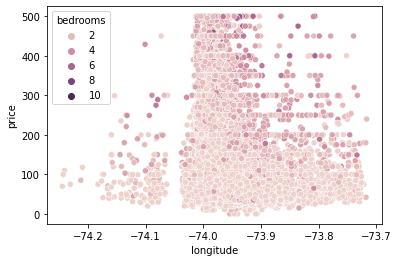

In [42]:
sns.scatterplot(x= listings['longitude'], y = listings['price'], hue = listings['bedrooms'])

### Ejercicio 5: (8 min)
Escriba el código aquí para trazar las primeras 1000 ubicaciones en el mapa donde el estacionamiento está disponible en color azul, y las primeras 1000 ubicaciones donde el estacionamiento no está disponible en color rojo. (Sugerencia: puede usar el comando: color = "azul" y "rojo" respectivamente).

**Respuesta.**

In [43]:
lat_log_parking_yes = listings.loc[ listings['parking']==1.0, ["latitude","longitude" ] ]
lat_log_parking_no = listings.loc[ listings['parking']==-1.0, ["latitude","longitude" ] ]
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")
for i in range(8000):
    marker = folium.CircleMarker(location=[lat_log_parking_yes["latitude"].iloc[i],lat_log_parking_yes["longitude"].iloc[i]],\
                                 radius=1,color="blue",fill=True)
    marker.add_to(folium_map)

for i in range(8000):
    marker = folium.CircleMarker(location=[lat_log_parking_no["latitude"].iloc[i],lat_log_parking_no["longitude"].iloc[i]],\
                                 radius=1,color="red",fill=True)
    marker.add_to(folium_map)    
    
folium_map

Output hidden; open in https://colab.research.google.com to view.

## Efectos de interaccion y posibles hipotesis(15 min)

Ahora que hemos explorado algunos de los factores que se espera que afecten el precio, centrémonos en comprender las correlaciones inesperadas, como la correlación negativa con el estacionamiento. Empezamos por lo último:

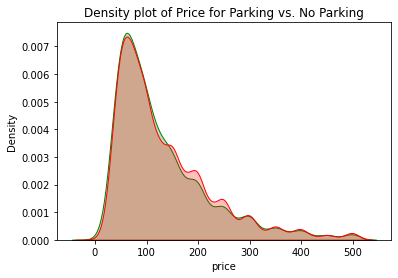

In [44]:
# First, plot parking vs. non-parking prices.
sns.kdeplot(listings.loc[listings['parking'] == 1,'price'],shade = True, label="Parking",color="g")
sns.kdeplot(listings.loc[listings['parking'] == -1,'price'],shade = True, label="No Parking",color="r")
plt.title("Density plot of Price for Parking vs. No Parking");

Vimos antes que la correlación entre precio y estacionamiento es -0.019383. Dado que el estacionamiento es deseable, esperamos que el precio aumente con el estacionamiento. Cuando vemos un patrón como este, debemos sospechar la existencia de **efectos de interacción** que están complicando la relación estacionamiento vs. precio. Los efectos de interacción se dan cuando la relación entre dos variables es **condicional** o depende del valor de una tercera variable oculta.

Le recomendamos encarecidamente que se apoye en su experiencia en el dominio al mirar los datos y realmente explore las correlaciones / relaciones que parecen divertidas, raras o contradictorias. Podemos encontrar efectos de interacción o podemos encontrar que ciertas suposiciones de larga data de nuestra experiencia en el dominio no son correctas (por ejemplo, tal vez el estacionamiento no sea deseable en ciertas partes del mundo).

Entonces, ¿cuál podría ser potencialmente esta tercera variable? Bueno, hemos visto que la ubicación tiene un gran impacto en los precios. ¿Quizás las áreas de precios altos no tienen muchos lugares de estacionamiento, mientras que las áreas de precios bajos sí? No lo sabemos con certeza, pero vale la pena adivinarlo.

Más formalmente, planteamos la hipótesis de que esta correlación negativa observada es el resultado de los efectos de interacción que surgen de la ubicación. Para investigar esta hipótesis, debemos desglosar las ubicaciones por vecindario y ver si esta correlación negativa entre precio y estacionamiento todavía se mantiene dentro de los vecindarios. Los vecindarios son discretos y hay muchos listados por vecindario, por lo que simplemente podemos calcular la correlación para cada vecindario individualmente. Matemáticamente, esto es exactamente lo mismo que condicionar la vecindad y calcular la correlación condicional.

# Parte 2

## Explorando efectos temporales: verano en Rio e invierno en Moscow (20 min)

Hemos visto que los gráficos condicionales pueden ser una forma útil de "corregir" las comparaciones teniendo en cuenta los efectos de interacción.

El tiempo es un efecto de interacción muy común que aparece en muchos conjuntos de datos. Para los datos de Airbnb, esto es especialmente importante, ya que Airbnb suele ser más caro cerca de las vacaciones, por lo que las estimaciones de precios razonables deben tener esto en cuenta. En la práctica, esta es una de las correcciones más importantes que ofrecen las empresas consultoras de precios de Airbnb, y las correcciones suelen aprovechar los datos agrupados de muchas ciudades algo similares. Esto es vital para lograr buenas correcciones, pero es fácil cometer errores al no tener en cuenta las diferencias importantes entre ciudades.

Comenzamos abriendo los datos del calendario y contando (i) el número de alquileres por día; y (ii) sus precios totales:

In [ ]:
cal = pd.read_csv('scal.csv', delimiter=',')
cal.head()
# Count rentals and total price on each date.

,date,price
0,20190709,149.0
1,20190709,76.0
2,20190710,76.0
3,20190711,76.0
4,20190712,76.0


In [ ]:
rcount = dict()
rprice = dict()

for row in cal.itertuples(index=True, name='Pandas'):
    rcount[str(row[1])] = rcount.get(str(row[1]), 0) + 1
    rprice[str(row[1])] = rprice.get(str(row[1]), 0) + row[2] 

In [ ]:
rcount
#rprice

{'20190708': 37078,
 '20190709': 48895,
 '20190710': 48895,
 '20190711': 48895,
 '20190712': 48895,
 '20190713': 48895,
 '20190714': 48895,
 '20190715': 48895,
 '20190716': 48895,
 '20190717': 48895,
 '20190718': 48895,
 '20190719': 48895,
 '20190720': 48895,
 '20190721': 48895,
 '20190722': 48895,
 '20190723': 48895,
 '20190724': 48895,
 '20190725': 48895,
 '20190726': 48895,
 '20190727': 48895,
 '20190728': 48895,
 '20190729': 48895,
 '20190730': 48895,
 '20190731': 48895,
 '20190801': 48895,
 '20190802': 48895,
 '20190803': 48895,
 '20190804': 48895,
 '20190805': 48895,
 '20190806': 48895,
 '20190807': 48895,
 '20190808': 48895,
 '20190809': 48895,
 '20190810': 48895,
 '20190811': 48895,
 '20190812': 48895,
 '20190813': 48895,
 '20190814': 48895,
 '20190815': 48895,
 '20190816': 48895,
 '20190817': 48895,
 '20190818': 48895,
 '20190819': 48895,
 '20190820': 48895,
 '20190821': 48895,
 '20190822': 48895,
 '20190823': 48895,
 '20190824': 48895,
 '20190825': 48895,
 '20190826': 48895,


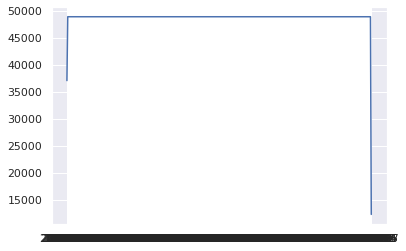

In [ ]:
# Plotear los resultados. 
tempcount = sorted(rcount.items())
x, y = zip(*tempcount) 
tempprice = sorted(rprice.items())
u,v = zip(*tempprice)

plt.plot(x, y)
plt.show()

In [ ]:
# Plotear el precio promedio

tempprice = sorted(rprice.items())
u,v = zip(*tempprice)

ratio = lambda a,b: float(a)/float(b) 

avgprice = list(map(ratio, v,y))

xd = pd.to_datetime(x)

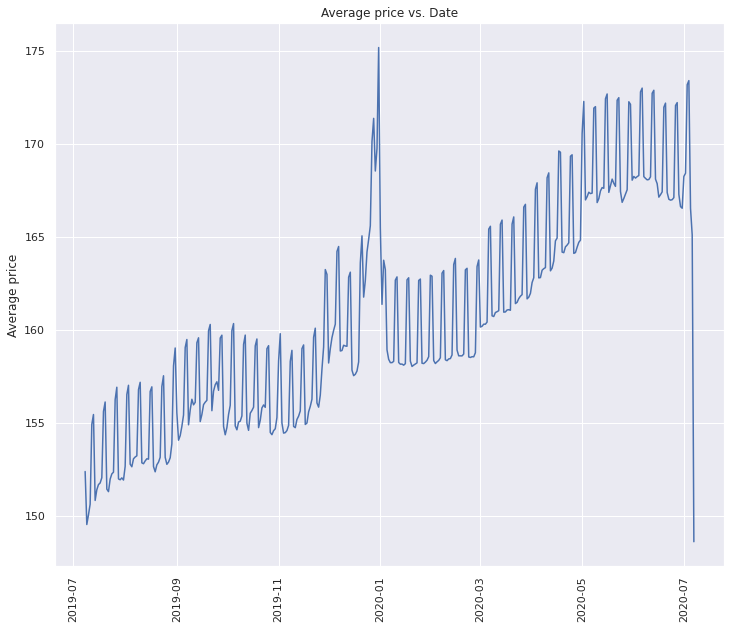

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(xd,avgprice)
plt.xticks(rotation = 'vertical')
plt.ylabel('Average price')
plt.title("Average price vs. Date")
plt.show()

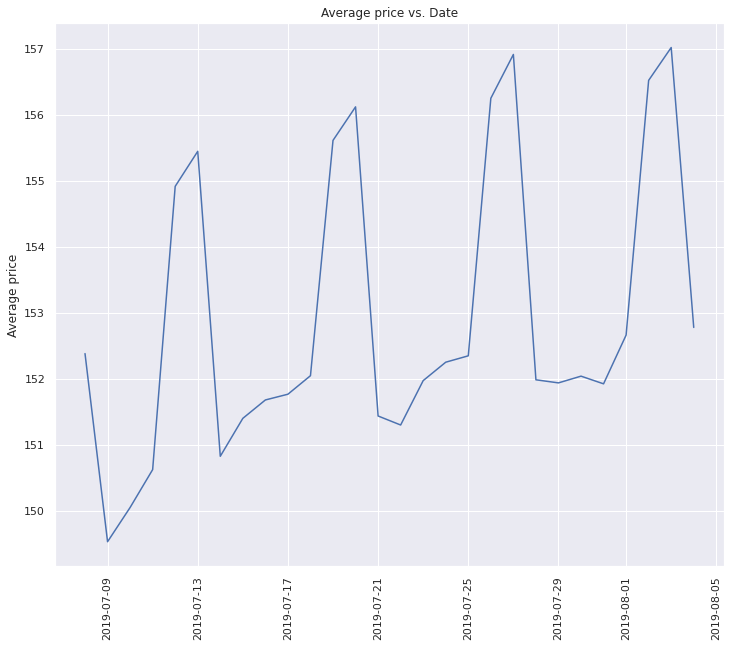

In [ ]:
# Ponerlo en una escala de tiempo mas pequeña
plt.figure(figsize=(12,10))
plt.plot(xd[0:28],avgprice[0:28])
plt.xticks(rotation = 'vertical')
plt.ylabel('Average price')
plt.title("Average price vs. Date")
plt.show()

Al analizar datos de series de tiempo como este, es común verlos como una suma de varios efectos contribuyentes a lo largo del tiempo más ruido. Los dos tipos comunes de sumandos en tal representación son:

1. **Seasonal effects**: este es un resumen que es periódico, a menudo con un período correspondiente al calendario (semana, mes o año).
2. **Trend effects**: se trata de un sumatorio suave que sube o baja lentamente a lo largo de una serie completa, lo que representa tendencias a largo plazo, como la inflación de precios.

### Ejercicio 8: (15 min)

#### 8.1 (6 min)

Visualmente, ¿puede ver algún componente fuerte de temporada o tendencia? ¿Qué quieren decir?

**Respuesta.**
1. Hay un componente cíclico extremadamente fuerte que se repite todas las semanas. Esto corresponde al hecho de que los viajes de fin de semana a Nueva York son muy diferentes a los viajes entre semana.
2. Existe una tendencia a incrementar los precios a lo largo del tiempo.
3. Componentes del calendario: este es un componente con "picos" agudos que está diseñado para corregir cualquier elemento idiosincrásico de nuestro calendario. Esto podría incluir: (i) una serie de tiempo mensual con una caída en febrero (ya que es el mes más corto); (ii) picos en meses que contienen cinco sábados (ya que puede haber más gastos los fines de semana); o (iii) una serie de tiempo diaria con una caída el Día del Trabajo (cuando las tiendas están cerradas).

#### 8.2 (3 min)

¿Cuál es el enorme pico que ves en este gráfico? ¿Es real y cómo describiría lo que está sucediendo en términos sencillos?

**Respuesta.** Este pico se produce en Navidad, la temporada navideña más concurrida. Lo esperamos todos los años y debemos incorporarlo en cualquier modelo razonable.

#### 8.3 (6 min)

¿Podemos adivinar la temporada más ocupada (excluyendo la Navidad) de esta tabla sin procesar?

**Respuesta.** Sería difícil. Tenga en cuenta que este gráfico cubre aproximadamente un año, pero hay una clara discontinuidad si intenta "ajustar" los datos (es decir, la diferencia entre el primer y el último día en este gráfico es significativa). Esto se debe a una tendencia subyacente de precios al alza cada año. Para determinar la mejor temporada, necesitaría extraer esta tendencia, lo cual es difícil de hacer a partir de los datos de un solo año en una sola ciudad.

Esto nos lleva a un tema importante: ¡incorporar conjuntos de datos auxiliares! El sitio web Inside Airbnb incluye datos de calendario para muchas ciudades, y podemos usarlos para ajustar el componente de tendencia. Para obtener algo de diversidad, debemos asegurarnos de obtener algunos datos de: (i) una ciudad cercana a Nueva York; (ii) una ciudad en los Estados Unidos con un clima muy diferente; y (iii) algunas ciudades muy lejanas.

## Conclusiones (5 min)

En este caso, vimos que los precios de Airbnb están influenciados por muchos factores. Algunos de los principales incluyen ubicación, fecha, número de dormitorios, número de huéspedes y tipo de propiedad.

Cualquier modelo futuro que construyamos debería incluir estos factores. La incorporación de algunos de estos factores, como el número de dormitorios, debería ser sencilla, ya que tiene una relación grande y casi lineal con el precio. Pero otros, como la ubicación, exhiben relaciones muy no lineales. Aprenderemos a lidiar con este tipo de relaciones complejas en casos futuros.

También encontramos algunas correlaciones sorprendentes, como la correlación negativa entre precio y estacionamiento. Sin embargo, después de desglosar los datos por barrios e incorporar el efecto de interacción de la ubicación, esta correlación negativa desapareció por completo.

Los efectos temporales son un tipo muy específico de efecto de interacción que debe tratarse por separado. Nuestra exploración nos dice que cualquier modelo de precios de AirBnB debe tener en cuenta los fuertes componentes estacionales, así como los fuertes picos alrededor de las principales festividades.